# Homework 05 – Model Monitoring
The goal of this homework is to familiarize users with monitoring for ML batch services, using PostgreSQL database to store metrics and Grafana to visualize them.

## Q1. Prepare the dataset

Start with `baseline_model_nyc_taxi_data.ipynb`. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

* 72044
* 78537 
* 57457
* 54396

### Baseline model for batch monitoring example

In [178]:
import os
import time
import logging 
import requests
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, ColumnSummaryMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from datetime import datetime, timedelta

import psycopg


In [4]:
data_directory = "data"
os.makedirs(data_directory, exist_ok=True)

files = [('green_tripdata_2024-03.parquet', f'./{data_directory}')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:03<00:00, 367876.58it/s, save to ./data/green_tripdata_2024-03.parquet]


In [124]:
df_2024_03 = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [125]:
df_2024_03.shape[0]

57457

## Q2. Metric

Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the `"fare_amount"` column (`quantile=0.5`).

Hint: explore evidently metric `ColumnQuantileMetric` (from `evidently.metrics import ColumnQuantileMetric`) 

What metric did you choose?


### Training

In [126]:
# create target
df_2024_03["duration_min"] = df_2024_03.lpep_dropoff_datetime - df_2024_03.lpep_pickup_datetime
df_2024_03.duration_min = df_2024_03.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [127]:
# filter out outliers
df_2024_03 = df_2024_03[(df_2024_03.duration_min >= 0) & (df_2024_03.duration_min <= 60)]
df_2024_03 = df_2024_03[(df_2024_03.passenger_count > 0) & (df_2024_03.passenger_count <= 8)]

<Axes: >

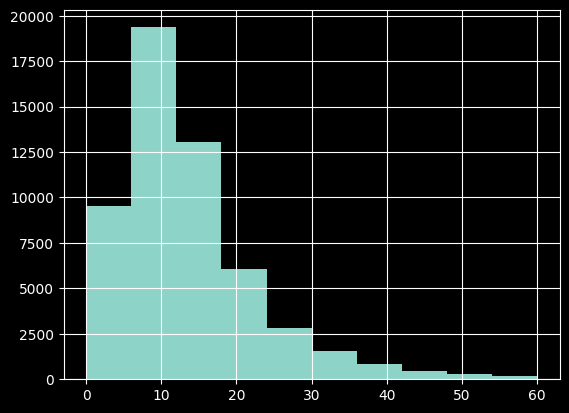

In [128]:
df_2024_03.duration_min.hist()

In [14]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [15]:
df_2024_03.shape

(54135, 21)

In [16]:
train_data = df_2024_03[:30000]
val_data = df_2024_03[30000:]

In [17]:
model = LinearRegression()

model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [18]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [19]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [26]:
print(f"MAE on train data = {mean_absolute_error(train_data.duration_min, train_data.prediction):.3f}")
print(f"MAE on valid data = {mean_absolute_error(val_data.duration_min, val_data.prediction):.3f}")

MAE on train data = 3.772
MAE on valid data = 3.717


### Dump model and reference data

In [27]:
os.makedirs("models", exist_ok=True)

with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [28]:
os.makedirs("data", exist_ok=True)

val_data.to_parquet('data/reference.parquet')

### Evidently Report

In [ ]:
# !docker compose up -d --build

In [33]:
# !evidently ui

Grafana → http://localhost:3000/ = admin/admin

Adminer → http://localhost:8080/ = Postgres/db/postgres/example/test

Evidently → http://localhost:8000/

In [34]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [107]:
report = Report(
    metrics=[
        ColumnDriftMetric(column_name='prediction'),
        DatasetDriftMetric(),
        DatasetMissingValuesMetric(),
        ColumnQuantileMetric(column_name='fare_amount', quantile=0.5),
        ColumnSummaryMetric(column_name="prediction"),
        ColumnSummaryMetric(column_name="trip_distance")
    ]
)

In [108]:
report.run(
        reference_data=train_data,
        current_data=val_data,
        column_mapping=column_mapping,
    )

In [ ]:
report.show(mode='inline')

In [110]:
result = report.as_dict()

In [119]:
print(f"Prediction Drift:\t{result['metrics'][0]['result']['drift_score']:.7f}")

Prediction Drift:	0.0100646


In [112]:
print(f"Quantile Value (Current):\t{result['metrics'][3]['result']['current']['value']}")
print(f"Quantile Value (Reference):\t{result['metrics'][3]['result']['reference']['value']}")

Quantile Value (Current):	13.5
Quantile Value (Reference):	13.5


In [113]:
print(f"Number of drifted columns:\t{result['metrics'][1]['result']['number_of_drifted_columns']:.7f}")

Number of drifted columns:	0.0000000


In [114]:
print(f"Share of missing values (Current):\t{result['metrics'][2]['result']['current']['share_of_missing_values']:.7f}")
print(f"Share of missing values (Reference):\t{result['metrics'][2]['result']['reference']['share_of_missing_values']:.7f}")

Share of missing values (Current):	0.0454583
Share of missing values (Reference):	0.0454606


In [117]:
print(f"Prediction Mean (Current):\t{result['metrics'][4]['result']['current_characteristics']['mean']:.7f}")
print(f"Prediction Mean (Reference):\t{result['metrics'][4]['result']['reference_characteristics']['mean']:.7f}")

print(f"Prediction Std Current):\t{result['metrics'][4]['result']['current_characteristics']['std']:.7f}")
print(f"Prediction Std (Reference):\t{result['metrics'][4]['result']['reference_characteristics']['std']:.7f}")

Prediction Mean (Current):	13.5200000
Prediction Mean (Reference):	13.4700000
Prediction Std Current):	7.0800000
Prediction Std (Reference):	6.9800000


In [118]:
print(f"Trip Distance Mean (Current):\t{result['metrics'][5]['result']['current_characteristics']['mean']:.7f}")
print(f"Trip Distance Mean (Reference):\t{result['metrics'][5]['result']['reference_characteristics']['mean']:.7f}")

print(f"Trip Distance Std Current):\t{result['metrics'][5]['result']['current_characteristics']['std']:.7f}")
print(f"Trip Distance Std (Reference):\t{result['metrics'][5]['result']['reference_characteristics']['std']:.7f}")

Trip Distance Mean (Current):	2.4900000
Trip Distance Mean (Reference):	2.4600000
Trip Distance Std Current):	2.4800000
Trip Distance Std (Reference):	2.4800000


In [ ]:
# !docker compose down


## Q3. Monitoring

Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024). 

What is the maximum value of metric `quantile = 0.5` on the `"fare_amount"` column during March 2024 (calculated daily)?

* 10
* 12.5
* 14.2
* 14.8

In [140]:
df_2024_03.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54135 entries, 0 to 55359
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               54135 non-null  int32         
 1   lpep_pickup_datetime   54135 non-null  datetime64[us]
 2   lpep_dropoff_datetime  54135 non-null  datetime64[us]
 3   store_and_fwd_flag     54135 non-null  object        
 4   RatecodeID             54135 non-null  float64       
 5   PULocationID           54135 non-null  int32         
 6   DOLocationID           54135 non-null  int32         
 7   passenger_count        54135 non-null  float64       
 8   trip_distance          54135 non-null  float64       
 9   fare_amount            54135 non-null  float64       
 10  extra                  54135 non-null  float64       
 11  mta_tax                54135 non-null  float64       
 12  tip_amount             54135 non-null  float64       
 13  tolls_

In [157]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [158]:
ws = Workspace("workspace")

In [159]:
project = ws.create_project("NYC Taxi Homework 05 Project 2")
project.description = "My project description"
project.save()

Project(id=UUID('04fb4351-084c-431a-a2af-b36e79b0b719'), name='NYC Taxi Homework 05 Project 2', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Homework 05 Project 2', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 23, 22, 37, 25, 665612))

In [180]:
create_daily_table_statement = """
drop table if exists day_metrics;
create table day_metrics(
	timestamp timestamp,
	quantile float
)
"""

In [181]:
def prep_db():
	with psycopg.connect("host=localhost port=5432 user=postgres password=example", autocommit=True) as conn:
		res = conn.execute("SELECT 1 FROM pg_database WHERE datname='test'")
		if len(res.fetchall()) == 0:
			conn.execute("create database test;")
		with psycopg.connect("host=localhost port=5432 dbname=test user=postgres password=example") as conn:
			conn.execute(create_daily_table_statement)

In [184]:
def calculate_daily_matrics(curr, day):
    day_data = df_2024_03[df_2024_03['lpep_pickup_datetime'].dt.date == day.date()]

    daily_report = Report(
        metrics=[
            ColumnQuantileMetric(
                column_name="fare_amount",
                quantile=0.5
            )
        ],
        timestamp=day
    )
    
    daily_report.run(
        # reference_data=df_2024_03,
        reference_data=None,
        current_data=day_data,
        column_mapping=column_mapping
    )

    quantile = daily_report.as_dict()['metrics'][0]['result']['current']['value']
    
    # Add report to the project
    ws.add_report(project.id, daily_report)

    curr.execute(
		"insert into day_metrics(timestamp, quantile) values (%s, %s)",
		(day, float(quantile))
	)

    return quantile

In [185]:
df_2024_03 = df_2024_03[
    (df_2024_03['lpep_pickup_datetime'].dt.date >= pd.to_datetime('2024-03-01').date()) 
    & (df_2024_03['lpep_pickup_datetime'].dt.date <= pd.to_datetime('2024-03-31').date())
]

day_quantiles = []

prep_db()
# logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s]: %(message)s")
SEND_TIMEOUT = 10
last_send = datetime.now() - timedelta(seconds=10)

with psycopg.connect("host=localhost port=5432 dbname=test user=postgres password=example", autocommit=True) as conn:
    for day in pd.date_range(start="2024-03-01", end="2024-03-31"):
        with conn.cursor() as curr:
            quantile = calculate_daily_matrics(curr, day)
            day_quantiles.append(quantile)

        new_send = datetime.now()
        seconds_elapsed = (new_send - last_send).total_seconds()
        if seconds_elapsed < SEND_TIMEOUT:
            time.sleep(SEND_TIMEOUT - seconds_elapsed)
        while last_send < new_send:
            last_send = last_send + timedelta(seconds=10)
        # logging.info("data sent")
    
max_quantile = max(day_quantiles)

max_quantile

14.2

In [161]:
project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Fare Amount Median (0.5 Quantile)",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="median"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('04fb4351-084c-431a-a2af-b36e79b0b719'), name='NYC Taxi Homework 05 Project 2', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Homework 05 Project 2', panels=[DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('250993dc-8a05-44fa-8cd2-62b888cbf45b'), title='Fare Amount Median (0.5 Quantile)', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.value', metric_id='ColumnQuantileMetric', metric_fingerprint=None, metric_args={}, legend='median')], plot_type=<PlotType.LINE: 'line'>)], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 23, 22, 37, 25, 665612))

### Dashboard from Evidently AI

![Fare Amount Median (0.5 Quantile)](FareAmountMedian_Evidently.png)

### Dashboard from Grafana

![Fare Amount Median (0.5 Quantile)](FareAmountMedian_Grafana.png)

## Q4. Dashboard


Finally, let’s add panels with new added metrics to the dashboard. After we customize the  dashboard let's save a dashboard config, so that we can access it later. Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

* `project_folder` (05-monitoring)
* `project_folder/config`  (05-monitoring/config)
* `project_folder/dashboards`  (05-monitoring/dashboards)
* `project_folder/data`  (05-monitoring/data)

In [186]:
# project_folder/dashboards